# Exploration and plot generation
This notebook generates many plots based on spells and spells_21_days.

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from itertools import chain
from collections import Counter
import re
import seaborn as sns  # for easier grouped histogram
import numpy as np

base = Path("/n/scratch/users/b/bef299/polypharmacy_project_fhd8SDd3U50/")


# --- Load data ---
input_suffix = "_sample1M"
output_suffix = "_sample1M_grace15_minspell7"
opioid_flag = True
if opioid_flag:
    input_suffix = "_opioid" + input_suffix
    output_suffix = "_opioid" + output_suffix
spells = pd.read_parquet(base / f"spells_with_labels{output_suffix}.parquet")
split_spells = pd.read_parquet(base / f"split_spells{output_suffix}.parquet")
# rx_fills = pd.read_parquet(base / f"rx_fills{input_suffix}.parquet")
demographics = pd.read_parquet(base / f"demographics{input_suffix}.parquet")
try:
    drug_changes = pd.read_parquet(base / f"drug_changes{output_suffix}.parquet")
except FileNotFoundError:
    print("Drug changes file not found.")
    drug_changes = pd.DataFrame()

In [12]:
drug_changes['spell_id'].nunique()

231001

📊 Summary of Gaps Between Spells (raw_exit → next entry)
-----------------------------------------------------------------
Version   |   Mean   Median   Std   Min   Max   Count
-----------------------------------------------------------------
15 days   | 191.50    68.00  314.79    16    3891   90,075
-----------------------------------------------------------------


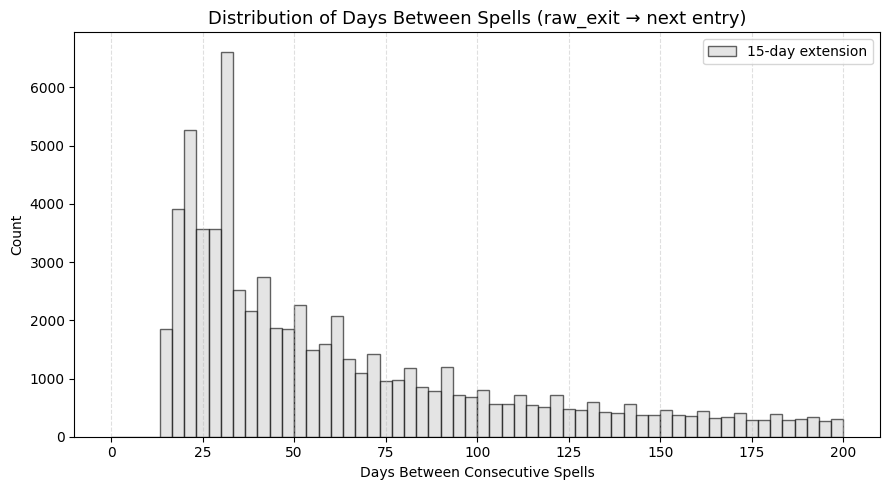

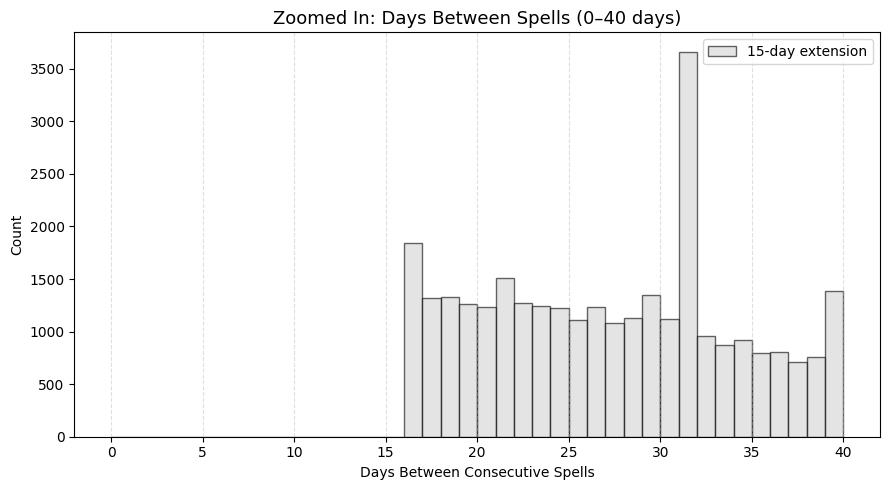

In [2]:
# --- Compare Gap Between Spells (15-day vs 21-day extensions) ---
def compute_gaps(spells_df):
    """Compute gap in days between consecutive spells for each patient."""
    # Ensure datetime types
    date_cols = ["entry_date", "raw_exit_date", "extended_exit_date", "followup_end_date"]
    for col in date_cols:
        if not np.issubdtype(spells_df[col].dtype, np.datetime64):
            spells_df[col] = pd.to_datetime(spells_df[col])
    
    # Sort and compute gap between raw_exit_date of previous spell and next entry_date
    spells_sorted = spells_df.sort_values(["MemberUID", "entry_date"]).copy()
    spells_sorted["days_since_prev_raw_exit"] = (
        spells_sorted["entry_date"] - spells_sorted.groupby("MemberUID")["raw_exit_date"].shift(1)
    ).dt.days
    
    return spells_sorted["days_since_prev_raw_exit"].dropna()

# Compute gaps for both versions
gaps = compute_gaps(spells)

# --- Summary stats ---
print("📊 Summary of Gaps Between Spells (raw_exit → next entry)")
print("-" * 65)
print("Version   |   Mean   Median   Std   Min   Max   Count")
print("-" * 65)
print(f"15 days   | {gaps.mean():6.2f}  {gaps.median():7.2f}  {gaps.std():6.2f}  {gaps.min():4.0f}  {gaps.max():6.0f}  {len(gaps):7,}")
print("-" * 65)

# --- Plot full histogram (0–200 days for clarity) ---
plt.figure(figsize=(9, 5))
plt.hist(gaps, bins=60, range=(0, 200), alpha=0.6, label="15-day extension", color="lightgray", edgecolor="black")
plt.title("Distribution of Days Between Spells (raw_exit → next entry)", fontsize=13)
plt.xlabel("Days Between Consecutive Spells")
plt.ylabel("Count")
plt.legend()
plt.grid(axis="x", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

# --- Zoomed-in histogram (0–40 days) ---
plt.figure(figsize=(9, 5))
plt.hist(gaps, bins=40, range=(0, 40), alpha=0.6, label="15-day extension", color="lightgray", edgecolor="black")
plt.title("Zoomed In: Days Between Spells (0–40 days)", fontsize=13)
plt.xlabel("Days Between Consecutive Spells")
plt.ylabel("Count")
plt.legend()
plt.grid(axis="x", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

In [3]:
# --- 🧮 Spell summary comparison (15 vs 21 day extensions) ---

def summarize_spells(label, df):
    """Get spell summary statistics."""
    total = len(df)
    one_per = len(df.drop_duplicates(subset=["MemberUID"], keep="first"))
    return total, one_per, one_per / total * 100

# Summaries
total, one, pct = summarize_spells("15-day", spells)

print("📊 Spell Summary Comparison")
print("-" * 60)
print(f"{'Config':<20}{'Total Spells':>15}{'1/Patient':>15}{'% of Total':>10}")
print("-" * 60)
print(f"{'15-day extension':<20}{total:>15,}{one:>15,}{pct:>9.2f}%")
print("-" * 60)

# Keep only the one-per-patient spells for further analysis
# spells = spells.drop_duplicates(subset=["MemberUID"], keep="first")


📊 Spell Summary Comparison
------------------------------------------------------------
Config                 Total Spells      1/Patient% of Total
------------------------------------------------------------
15-day extension            160,762         70,687    43.97%
------------------------------------------------------------


In [7]:
ae_freq_df.head()

NameError: name 'ae_freq_df' is not defined


📋 Top Adverse Event Codes and Descriptions
--------------------------------------------------------------------------------
CodeValue  count                                                                                         Description  % of Total
    F1120    922                                              Mental and behavioural disorders due to use of opioids       31.18
    F1190    281                                              Mental and behavioural disorders due to use of opioids        9.50
  T7840XA    223                                                            Adverse effects not elsewhere classified        7.54
    F1920    191  Mental and behavioural disorders due to multiple drug use and use of other psychoactive substances        6.46
    F1910    188  Mental and behavioural disorders due to multiple drug use and use of other psychoactive substances        6.36
    F1110    166                                              Mental and behavioural disorders due to

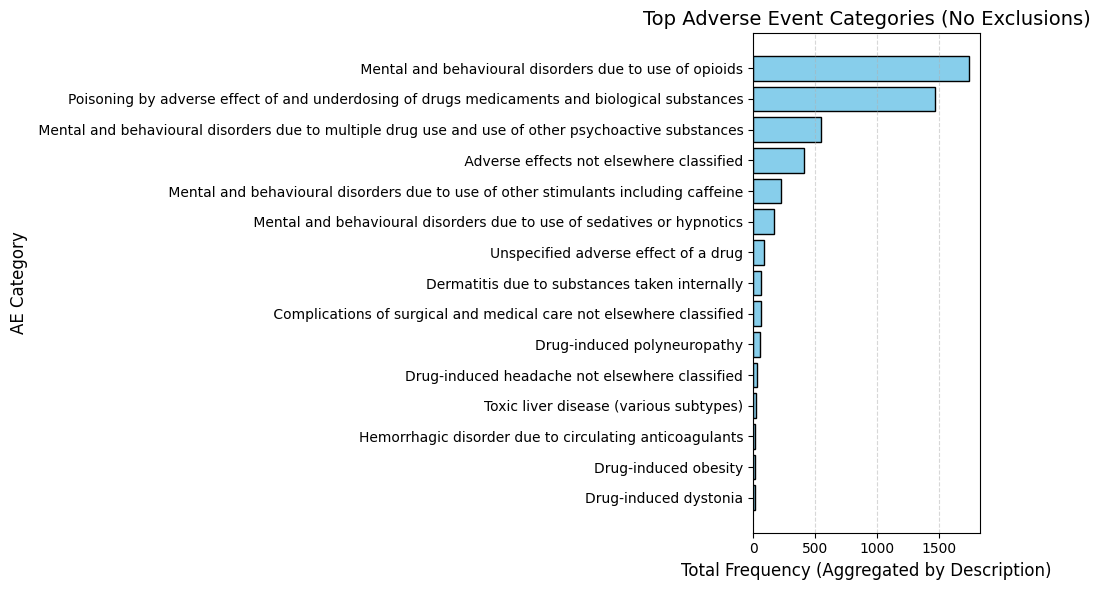


🧮 Aggregated AE Category Counts (for plot)
                                                                                        Description  count
                                             Mental and behavioural disorders due to use of opioids   1741
      Poisoning by adverse effect of and underdosing of drugs medicaments and biological substances   1463
 Mental and behavioural disorders due to multiple drug use and use of other psychoactive substances    547
                                                           Adverse effects not elsewhere classified    410
                 Mental and behavioural disorders due to use of other stimulants including caffeine    229
                              Mental and behavioural disorders due to use of sedatives or hypnotics    170
                                                               Unspecified adverse effect of a drug     88
                                                      Dermatitis due to substances taken internally 

In [ ]:
# --- ⚙️ Flatten AE codes across all AE spells ---
# If 'first_ae_code' doesn’t exist, replace it with your AE column (e.g. 'ae_codes')
ae_freq_df = (
    spells["first_ae_code"]
    .value_counts()
    .reset_index()
    .rename(columns={"first_ae_code": "CodeValue"})
)

# --- 📖 Read mapping CSV (with lazy SQL-like patterns) ---
ae_map = pd.read_csv("data/icd10_codes.csv")  # columns: code, description

def map_description(code):
    """Return AE description using SQL-like % wildcards."""
    for _, row in ae_map.iterrows():
        pattern = row["code"].replace("%", "")
        if str(code).startswith(pattern):
            return row["description"]
    return "Unknown AE code"

# Map descriptions
ae_freq_df["Description"] = ae_freq_df["CodeValue"].apply(map_description)

# --- 📊 Summary Table of Top AE Codes ---
top_n = 15
top_ae_df = ae_freq_df.head(top_n).copy()
top_ae_df["% of Total"] = (
    top_ae_df["count"] / top_ae_df["count"].sum() * 100
).round(2)

print("\n📋 Top Adverse Event Codes and Descriptions")
print("-" * 80)
print(top_ae_df.to_string(index=False))
print("-" * 80)
print(f"Showing top {top_n} AE categories out of {len(ae_freq_df):,} total unique codes.\n")

# --- 🔢 Aggregate by Description for visualization ---
agg_by_desc = (
    ae_freq_df.groupby("Description", as_index=False)["count"]
    .sum()
    .sort_values("count", ascending=False)
)

# Take top N descriptions for plotting
top_desc = agg_by_desc.head(top_n)

# --- 🎨 Visualization ---
plt.figure(figsize=(10, 6))
plt.barh(top_desc["Description"], top_desc["count"], color="skyblue", edgecolor="black")
plt.gca().invert_yaxis()  # Highest on top
plt.title("Top Adverse Event Categories (No Exclusions)", fontsize=14)
plt.xlabel("Total Frequency (Aggregated by Description)", fontsize=12)
plt.ylabel("AE Category", fontsize=12)
plt.grid(axis="x", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# --- 🧮 Print small summary of aggregation ---
print("\n🧮 Aggregated AE Category Counts (for plot)")
print(top_desc.to_string(index=False))


📊 AE Positioning Within Spell
--------------------------------------------------
count    5001.000000
mean      112.035593
std       192.843837
min         0.000000
25%        15.000000
50%        41.000000
75%       119.000000
max      2450.000000
Name: days_into_spell, dtype: float64


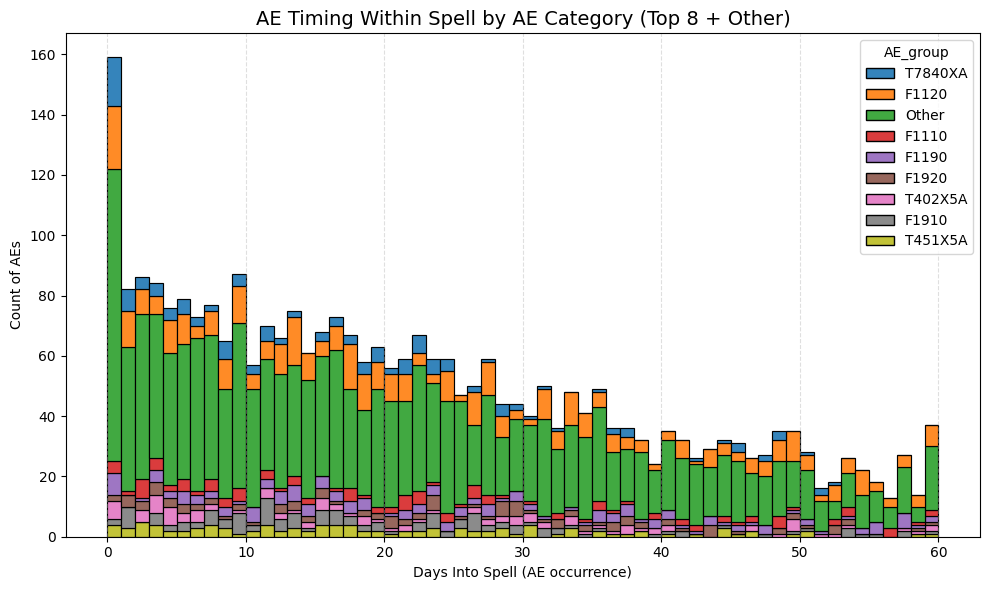

In [5]:
# --- 🧭 AE positioning within spell (days into spell) ---
ae_spells = spells[spells["had_ae"]].copy()

# Ensure datetime
ae_spells["entry_date"] = pd.to_datetime(ae_spells["entry_date"])
ae_spells["first_ae_date"] = pd.to_datetime(ae_spells["first_ae_date"])

# Compute days into spell
ae_spells["days_into_spell"] = (ae_spells["first_ae_date"] - ae_spells["entry_date"]).dt.days

# --- 📊 Summary ---
print("\n📊 AE Positioning Within Spell")
print("-" * 50)
print(ae_spells["days_into_spell"].describe())

# --- 🧩 Identify top AE categories (based on frequency of first_ae_code) ---
top_n = 8
top_codes = (
    ae_spells["first_ae_code"]
    .value_counts()
    .head(top_n)
    .index
    .tolist()
)

# Create a grouped category column
ae_spells["AE_group"] = ae_spells["first_ae_code"].apply(
    lambda x: x if x in top_codes else "Other"
)

# --- 🎨 Plot histogram coloured by AE category ---
plt.figure(figsize=(10, 6))
sns.histplot(
    data=ae_spells,
    x="days_into_spell",
    hue="AE_group",
    bins=60,
    binrange=(0, 60),
    multiple="stack",
    edgecolor="black",
    alpha=0.9
)
plt.title("AE Timing Within Spell by AE Category (Top 8 + Other)", fontsize=14)
plt.xlabel("Days Into Spell (AE occurrence)")
plt.ylabel("Count of AEs")
plt.grid(axis="x", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


📊 AE Positioning Within Spell
--------------------------------------------------
count    5001.000000
mean       11.696861
std        33.146965
min         0.000000
25%         0.000000
50%         4.000000
75%        14.000000
max      1713.000000
Name: days_into_spell, dtype: float64


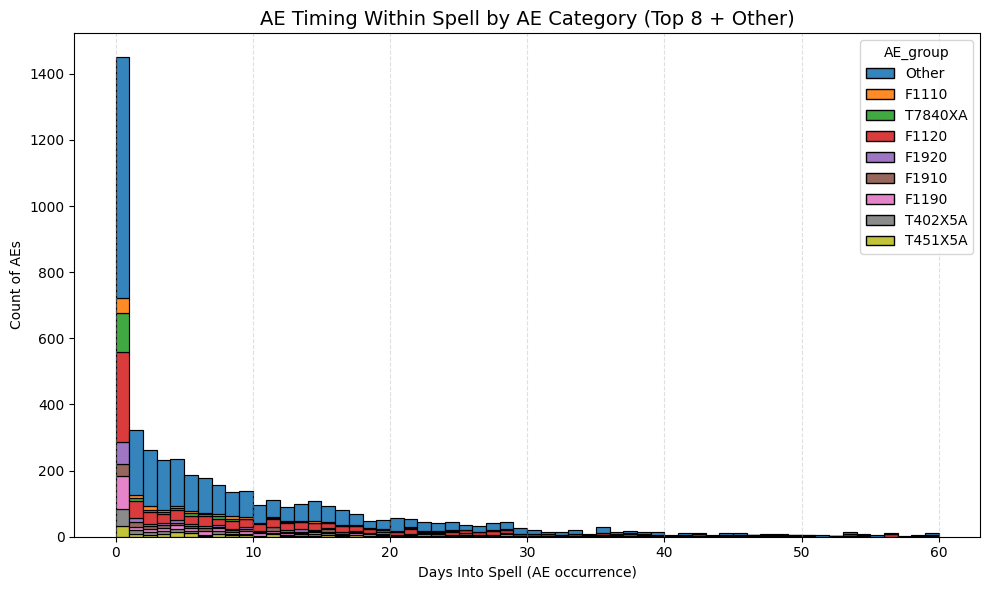

In [10]:
# --- 🧭 AE positioning within split_spells (days into spell) ---
ae_spells_split = split_spells[split_spells["had_ae"]].copy()

# Ensure datetime
ae_spells_split["entry_date"] = pd.to_datetime(ae_spells_split["entry_date"])
ae_spells_split["first_ae_date"] = pd.to_datetime(ae_spells_split["first_ae_date"])

# Compute days into spell
ae_spells_split["days_into_spell"] = (ae_spells_split["first_ae_date"] - ae_spells_split["entry_date"]).dt.days

# --- 📊 Summary ---
print("\n📊 AE Positioning Within Spell")
print("-" * 50)
print(ae_spells_split["days_into_spell"].describe())

# --- 🧩 Identify top AE categories (based on frequency of first_ae_code) ---
top_n = 8
top_codes = (
    ae_spells_split["first_ae_code"]
    .value_counts()
    .head(top_n)
    .index
    .tolist()
)

# Create a grouped category column
ae_spells_split["AE_group"] = ae_spells_split["first_ae_code"].apply(
    lambda x: x if x in top_codes else "Other"
)

# --- 🎨 Plot histogram coloured by AE category ---
plt.figure(figsize=(10, 6))
sns.histplot(
    data=ae_spells_split,
    x="days_into_spell",
    hue="AE_group",
    bins=60,
    binrange=(0, 60),
    multiple="stack",
    edgecolor="black",
    alpha=0.9
)
plt.title("AE Timing Within Spell by AE Category (Top 8 + Other)", fontsize=14)
plt.xlabel("Days Into Spell (AE occurrence)")
plt.ylabel("Count of AEs")
plt.grid(axis="x", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

In [ ]:
# Code to take the letter + two digits of ICD-10 codes for comorbidity grouping. Show how many comorbidities per patient.

In [17]:
# --- 👥 Demographics Comparison: AE vs Non-AE ---

# Define AE and Non-AE members
ae_members = ae_spells["MemberUID"].unique()
non_ae_members = spells_21_days.loc[~spells_21_days["MemberUID"].isin(ae_members), "MemberUID"].unique()

ae_demo = demographics[demographics["MemberUID"].isin(ae_members)].copy()
non_ae_demo = demographics[demographics["MemberUID"].isin(non_ae_members)].copy()

print(f"\n📊 Demographics Summary")
print("-" * 60)
print(f"AE patients: {len(ae_demo):,}")
print(f"Non-AE patients: {len(non_ae_demo):,}")
print("-" * 60)

# --- Gender distribution ---
gender_ae = ae_demo["gendercode"].value_counts(normalize=True).rename("AE (%)") * 100
gender_non = non_ae_demo["gendercode"].value_counts(normalize=True).rename("Non-AE (%)") * 100
gender_table = pd.concat([gender_ae, gender_non], axis=1).fillna(0).round(2)

# --- Race / Ethnicity distribution ---
race_ae = ae_demo["raceethnicitytypecode"].value_counts(normalize=True).rename("AE (%)") * 100
race_non = non_ae_demo["raceethnicitytypecode"].value_counts(normalize=True).rename("Non-AE (%)") * 100
race_table = pd.concat([race_ae, race_non], axis=1).fillna(0).round(2)

# --- State distribution (Top 10 AE states) ---
state_ae = ae_demo["statecode"].value_counts(normalize=True).rename("AE (%)") * 100
state_non = non_ae_demo["statecode"].value_counts(normalize=True).rename("Non-AE (%)") * 100
# Restrict to top 10 AE states for clarity
top_states = state_ae.head(10).index
state_table = pd.concat([state_ae.loc[top_states], state_non.loc[top_states]], axis=1).fillna(0).round(2)

# --- Display results ---
print("\n🧍 Gender Distribution (% of group):")
print(gender_table.to_string())

print("\n🌎 Race / Ethnicity Distribution (% of group):")
print(race_table.to_string())

print("\n📍 Top 10 States (by AE frequency, % of group):")
print(state_table.to_string())



📊 Demographics Summary
------------------------------------------------------------
AE patients: 10,616
Non-AE patients: 45,802
------------------------------------------------------------

🧍 Gender Distribution (% of group):
            AE (%)  Non-AE (%)
gendercode                    
F            65.11       60.37
M            34.89       39.63

🌎 Race / Ethnicity Distribution (% of group):
                       AE (%)  Non-AE (%)
raceethnicitytypecode                    
09                      45.25       50.91
01                      33.72       26.55
02                       9.83        9.54
11                       5.11        5.77
06                       4.81        5.84
04                       1.26        1.40

📍 Top 10 States (by AE frequency, % of group):
           AE (%)  Non-AE (%)
statecode                    
CA          11.19       12.00
TX           7.93        6.97
MI           6.46        5.12
OH           6.32        6.52
NY           5.64        7.65
IL      